In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from LinearRegression import LinearModel
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    explained_variance_score, max_error
)
from sklearn.model_selection import train_test_split, cross_val_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

sns.set_palette("Spectral")

# Set a base style
sns.set_style("whitegrid")

# Customize specific style parameters
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.color": "#cccccc",
    "axes.facecolor": "#f0f0f0",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}
sns.set_context("notebook", rc=custom_params)

Epoch 1, Training Loss: 3385.6781, Validation Loss: 3260.6875, Learning Rate: 0.001000
Epoch 101, Training Loss: 4.0848, Validation Loss: 4.5410, Learning Rate: 0.000905
Early stopping triggered at epoch 134. No significant improvement for 50 epochs. Best loss: 4.527400
Epoch 1, Training Loss: 3391.6959, Validation Loss: 3208.9833, Learning Rate: 0.001000
Epoch 101, Training Loss: 4.1476, Validation Loss: 4.1448, Learning Rate: 0.000905
Early stopping triggered at epoch 148. No significant improvement for 50 epochs. Best loss: 4.140317
Epoch 1, Training Loss: 3381.8847, Validation Loss: 3194.6299, Learning Rate: 0.001000
Epoch 101, Training Loss: 4.2060, Validation Loss: 3.9487, Learning Rate: 0.000905
Early stopping triggered at epoch 148. No significant improvement for 50 epochs. Best loss: 3.944496
Epoch 1, Training Loss: 3393.4717, Validation Loss: 3231.8165, Learning Rate: 0.001000
Epoch 101, Training Loss: 4.2436, Validation Loss: 4.0534, Learning Rate: 0.000905
Early stopping tr

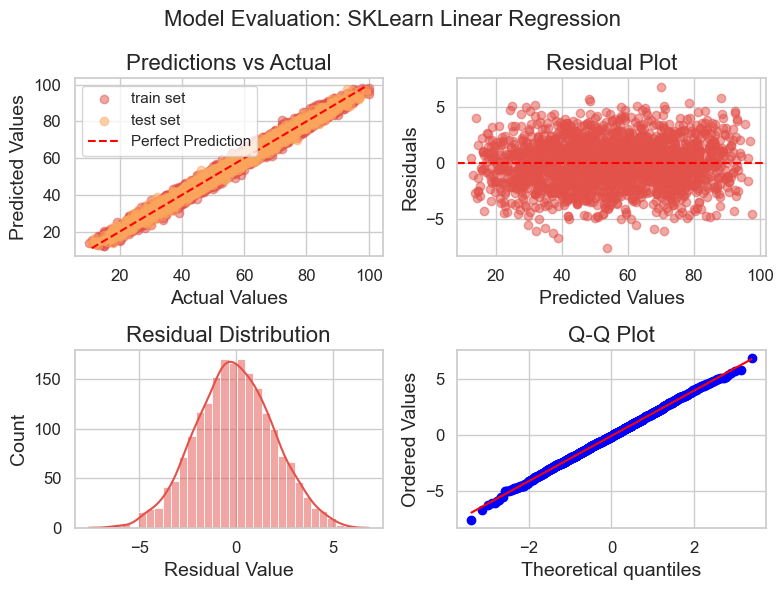

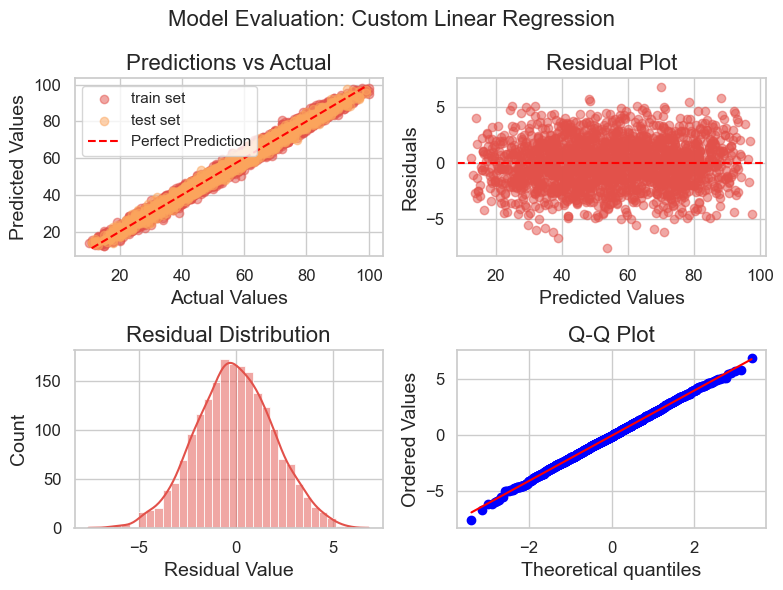


SKLearn Linear Regression Summary:

Test Set Metrics:
R2                       :     0.9890
MSE                      :     4.0826
RMSE                     :     2.0206
MAE                      :     1.6111
Explained Variance       :     0.9890
Max Error                :     7.6159
Mean Absolute % Error    :     3.4999

Residual Analysis (Test Set):
Residual Mean            :    -0.0798
Residual Std             :     2.0190
Residual Skewness        :    -0.0144
Residual Kurtosis        :    -0.0141
Shapiro-Wilk p-value     :     0.9763

Cross-Validation Results:
Mean R² Score:     0.9887 (±    0.0004)

Model Comparison Metrics:
R² Train-Test Gap:    -0.0003
RMSE Train-Test Gap:     0.0214

Custom Linear Regression Summary:

Test Set Metrics:
R2                       :     0.9890
MSE                      :     4.0756
RMSE                     :     2.0188
MAE                      :     1.6090
Explained Variance       :     0.9890
Max Error                :     7.6036
Mean Absolute % Erro

In [3]:
# Create example dataset for testing
np.random.seed(42)
data = pd.read_csv('Student_Performance.csv')

# Define feature columns
numeric_features = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
categorical_features = ['Extracurricular Activities']

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipelines for both models
sklearn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

custom_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearModel(
    learning_rate=0.001,  # Lower learning rate for stability
    epochs=2000,         # More epochs since we have early stopping
    batch_size=64,       # Larger batch size for housing data
    validation_split=0.2,
    tolerance=1e-6,
    patience=50,
    decay=0.999,         # Slower decay
    regularization=1e-5, # Lighter regularization
    regularization_type='L2',
    decay_type='exponential',
    verbose=100,
    clip_value=1.0,      # Conservative gradient clipping
    random_state=42
    ))
])

class ModelEvaluator:
    """
    A comprehensive model evaluation class that provides detailed metrics,
    visualizations, and statistical analysis for regression models.
    """
    
    def __init__(self, random_state: int = 42):
        """Initialize the evaluator with a random state for reproducibility."""
        self.random_state = random_state
        self.results = {}
        self.predictions = {}
        
    def _calculate_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate a comprehensive set of regression metrics."""
        metrics = {
            'R2': r2_score(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'Explained Variance': explained_variance_score(y_true, y_pred),
            'Max Error': max_error(y_true, y_pred)
        }
        
        # Calculate MAPE only if there are no zero values in y_true
        if not np.any(y_true == 0):
            metrics['Mean Absolute % Error'] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        return metrics
    
    def _perform_residual_analysis(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Perform statistical analysis on residuals."""
        residuals = y_true - y_pred
        residual_stats = {
            'Residual Mean': np.mean(residuals),
            'Residual Std': np.std(residuals),
            'Residual Skewness': stats.skew(residuals),
            'Residual Kurtosis': stats.kurtosis(residuals),
            'Shapiro-Wilk p-value': stats.shapiro(residuals)[1]
        }
        return residual_stats
    
    def evaluate_models(self, 
                       data: pd.DataFrame,
                       pipelines: Dict[str, Any],
                       target_col: str,
                       test_size: float = 0.2,
                       cv_folds: int = 5) -> Dict[str, Dict[str, Any]]:
        """
        Evaluate multiple models with detailed metrics and statistical analysis.
        
        Args:
            data: Input DataFrame
            pipelines: Dictionary of pipeline names and their corresponding objects
            target_col: Name of the target column
            test_size: Proportion of test split
            cv_folds: Number of cross-validation folds
        """
        # Split data
        X = data.drop(target_col, axis=1)
        y = data[target_col]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state
        )
        
        for name, pipeline in pipelines.items():
            # Fit the pipeline
            pipeline.fit(X_train, y_train)
            
            # Generate predictions
            y_pred_train = pipeline.predict(X_train)
            y_pred_test = pipeline.predict(X_test)
            
            # Store predictions for later visualization
            self.predictions[name] = {
                'train': {'true': y_train, 'pred': y_pred_train},
                'test': {'true': y_test, 'pred': y_pred_test}
            }
            
            # Calculate metrics
            train_metrics = self._calculate_metrics(y_train, y_pred_train)
            test_metrics = self._calculate_metrics(y_test, y_pred_test)
            
            # Perform residual analysis
            train_residuals = self._perform_residual_analysis(y_train, y_pred_train)
            test_residuals = self._perform_residual_analysis(y_test, y_pred_test)
            
            # Calculate cross-validation scores
            cv_scores = cross_val_score(pipeline, X, y, cv=cv_folds, scoring='r2')
            
            # Store all results
            self.results[name] = {
                'Train Metrics': train_metrics,
                'Test Metrics': test_metrics,
                'Train Residual Analysis': train_residuals,
                'Test Residual Analysis': test_residuals,
                'Cross Validation': {
                    'Mean R2': cv_scores.mean(),
                    'Std R2': cv_scores.std(),
                    'All Scores': cv_scores
                }
            }
        
        return self.results
    
    def plot_results(self, save_path: str = None):
        """Generate comprehensive visualization of model performance."""
        for model_name, preds in self.predictions.items():
            fig, axes = plt.subplots(2, 2, figsize=(8, 6))
            fig.suptitle(f'Model Evaluation: {model_name}', fontsize=16)
            
            # Scatter plot of predictions vs actual
            for idx, split in enumerate(['train', 'test']):
                data = preds[split]
                axes[0, 0].scatter(data['true'], data['pred'], 
                                 alpha=0.5, label=f'{split} set')
            
            axes[0, 0].plot([min(data['true']), max(data['true'])],
                          [min(data['true']), max(data['true'])],
                          'r--', label='Perfect Prediction')
            axes[0, 0].set_title('Predictions vs Actual')
            axes[0, 0].set_xlabel('Actual Values')
            axes[0, 0].set_ylabel('Predicted Values')
            axes[0, 0].legend()
            
            # Residual plot
            residuals = preds['test']['true'] - preds['test']['pred']
            axes[0, 1].scatter(preds['test']['pred'], residuals, alpha=0.5)
            axes[0, 1].axhline(y=0, color='r', linestyle='--')
            axes[0, 1].set_title('Residual Plot')
            axes[0, 1].set_xlabel('Predicted Values')
            axes[0, 1].set_ylabel('Residuals')
            
            # Residual distribution
            sns.histplot(residuals, kde=True, ax=axes[1, 0])
            axes[1, 0].set_title('Residual Distribution')
            axes[1, 0].set_xlabel('Residual Value')
            
            # Q-Q plot
            stats.probplot(residuals, dist="norm", plot=axes[1, 1])
            axes[1, 1].set_title('Q-Q Plot')
            
            plt.tight_layout()
            if save_path:
                plt.savefig(f"{save_path}_{model_name}.png")
            plt.show()
    
    def print_summary(self):
        """Print a formatted summary of all evaluation metrics."""
        for model_name, metrics in self.results.items():
            print(f"\n{'='*80}\n{model_name} Summary:\n{'='*80}")
            
            # Print main metrics
            print("\nTest Set Metrics:")
            for metric, value in metrics['Test Metrics'].items():
                print(f"{metric:25s}: {value:10.4f}")
            
            # Print residual analysis
            print("\nResidual Analysis (Test Set):")
            for stat, value in metrics['Test Residual Analysis'].items():
                print(f"{stat:25s}: {value:10.4f}")
            
            # Print cross-validation results
            print("\nCross-Validation Results:")
            cv_results = metrics['Cross Validation']
            print(f"Mean R² Score: {cv_results['Mean R2']:10.4f} (±{cv_results['Std R2']:10.4f})")
            
            print("\nModel Comparison Metrics:")
            train_metrics = metrics['Train Metrics']
            test_metrics = metrics['Test Metrics']
            print(f"R² Train-Test Gap: {train_metrics['R2'] - test_metrics['R2']:10.4f}")
            print(f"RMSE Train-Test Gap: {train_metrics['RMSE'] - test_metrics['RMSE']:10.4f}")

# Example usage
if __name__ == "__main__":
    # Initialize evaluator
    evaluator = ModelEvaluator(random_state=42)
    
    # Create dictionary of pipelines
    pipelines = {
        'SKLearn Linear Regression': sklearn_pipeline,
        'Custom Linear Regression': custom_pipeline
    }
    
    # Evaluate models
    results = evaluator.evaluate_models(
        data=data,
        pipelines=pipelines,
        target_col='Performance Index'
    )
    
    # Generate visualizations
    evaluator.plot_results()
    
    # Print detailed summary
    evaluator.print_summary()